<a href="https://colab.research.google.com/github/glentls/WHI_Data-Analysis/blob/main/World_Happiness_Index_Inflation_EDA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the necessary packages

In [ ]:
#import the neessary libraries for exploratory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Setting Project Parameters

In [ ]:
#Project Parameters
TARGET_COL = None
MAX_CAT_PREVIEW = 25
RANDOM_STATE = 42
SAVE_PLOTS = False
AUTO_PARSE_DATETIMES = True

# Reading the DataSet

In [ ]:
#import the WHI_Inflation.csv file
df = pd.read_csv('WHI_Inflation.csv')

This data is an unbalaned country year panel data combining metrics from the World Happiness Indexes and economic indexes of countries.
- Each inflation indicator has a bad connotation in higher values, however, a moderate value such as 2% for headline inflation is better than zero or negative inflation
- Other indexes includes: Score (higher better), GDP Per capita (Higher better), Healthy life expectancy (Higher better), Social Support (Higher better), Freedom to make life choices (higher better), Generosity (Higher better), Perceptions of corruption (Higher, worse)

# Quick Scan of the data

In [ ]:
#Quick scan of the data
#whii_data.describe()

#shape
print(df.shape)
print('\n')

#list of columns
print(list(df.columns))
print('\n')

#list of datatypes
print(df.dtypes)
print('\n')

df.sample(min(len(df), 5), random_state= RANDOM_STATE)



(1232, 16)


['Headline Consumer Price Inflation', 'Energy Consumer Price Inflation', 'Food Consumer Price Inflation', 'Official Core Consumer Price Inflation', 'Producer Price Inflation', 'GDP deflator Index growth rate', 'Score', 'GDP per Capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Country', 'Year', 'Continent/Region']


Headline Consumer Price Inflation         float64
Energy Consumer Price Inflation           float64
Food Consumer Price Inflation             float64
Official Core Consumer Price Inflation    float64
Producer Price Inflation                  float64
GDP deflator Index growth rate            float64
Score                                     float64
GDP per Capita                            float64
Social support                            float64
Healthy life expectancy at birth          float64
Freedom to make life choices              float64
Generosity                    

,Headline Consumer Price Inflation,Energy Consumer Price Inflation,Food Consumer Price Inflation,Official Core Consumer Price Inflation,Producer Price Inflation,GDP deflator Index growth rate,Score,GDP per Capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Country,Year,Continent/Region
549,-0.209740,-0.099460,-0.282796,-0.164016,-0.178162,-0.139680,-1.215191,0.577890,-0.230466,-0.617992,0.370426,-1.245890,0.343889,Jordan,2023,Middle East and North Africa
1050,-0.218513,0.046479,-0.220522,-0.378699,0.048231,-0.155347,1.572961,1.025604,1.267899,0.992529,0.987241,1.682473,2.180868,Sweden,2017,Western Europe
244,-0.257451,-0.262295,-0.373833,-0.505761,-0.277471,-0.084005,-0.140994,0.066881,-0.816985,0.312554,1.135624,-0.916959,-0.142730,China,2021,East Asia
553,-0.051286,-0.347270,-0.117382,0.742729,1.310447,0.070213,0.256432,0.248278,1.381708,0.173177,-0.034678,-0.428009,-0.107972,Kazakhstan,2018,Commonwealth of Independent States
1165,-0.377422,-0.618230,-0.158640,-0.175615,-0.178162,-0.561040,1.138348,0.885572,0.585158,0.816010,1.244527,0.751304,0.754158,United Arab Emirates,2020,Middle East and North Africa


# Checking the health of data and missing values and Statistical Summary

In [ ]:
#data health checks
missing = df.isna().sum().sort_values(ascending=False)
print(f'Sum of missing value \n{missing}')
print('\n')

#duplicate rows check
dupes = df.duplicated().sum()
print(f'duplicate {dupes}')
print('\n')

#numeric columns and categorical columns
num_cols = df.select_dtypes(include = np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude = np.number).columns.tolist()
print(f'numeric columns {num_cols}')
print(f'categorical columns {cat_cols}')
print('\n')

if num_cols:
    print("\nNumeric describe (25%,50%,75%):")
    print(df[num_cols].describe(percentiles=[0.25, 0.5, 0.75]).T)



Sum of missing value 
Headline Consumer Price Inflation         0
Energy Consumer Price Inflation           0
Food Consumer Price Inflation             0
Official Core Consumer Price Inflation    0
Producer Price Inflation                  0
GDP deflator Index growth rate            0
Score                                     0
GDP per Capita                            0
Social support                            0
Healthy life expectancy at birth          0
Freedom to make life choices              0
Generosity                                0
Perceptions of corruption                 0
Country                                   0
Year                                      0
Continent/Region                          0
dtype: int64


duplicate 0


numeric columns ['Headline Consumer Price Inflation', 'Energy Consumer Price Inflation', 'Food Consumer Price Inflation', 'Official Core Consumer Price Inflation', 'Producer Price Inflation', 'GDP deflator Index growth rate', 'Score', 'GDP per C

We noticed that there are some missing values. And hence, will fill them in later. For numerical data, we will use median, and Categorical data, we use most frequent. However, there are no categorical data missing.

In this correlation heatmap, we see a relationship between
- Inflation (all kinds) and Happiness (Score)
- Inflation (all kinds) with GDP Percapita
- Social indexes: (Social Support, Generosity, Freedom) and Happiness

Hence, these are relationships worth exploration

# Cleaning and Standardizing data

In [ ]:
# Identify columns
all_cols = df.columns.tolist()

#changing all columns to numerics if possible
for col in [c for c in df.columns if c not in ["Country", "Continent/Region"]]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

num_features = [c for c in num_cols if c.lower() != "year"]  # exclude year
raw_keep = [c for c in all_cols if c not in num_features]
print(len(num_features) + len(raw_keep))

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_pipeline, num_features)],
    remainder="passthrough"
)

X_mixed = preprocess.fit_transform(df)


out_cols = num_features + raw_keep
X_mixed_df = pd.DataFrame(X_mixed, columns=out_cols, index=df.index)
df = X_mixed_df
for col in [c for c in df.columns if c not in ["Country", "Continent/Region"]]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df.head()

16


,Headline Consumer Price Inflation,Energy Consumer Price Inflation,Food Consumer Price Inflation,Official Core Consumer Price Inflation,Producer Price Inflation,GDP deflator Index growth rate,Score,GDP per Capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Country,Year,Continent/Region
0,-0.320267,-0.655454,-0.339468,-0.646908,-0.178162,-0.138457,-1.695451,-1.572728,-2.267189,-1.169966,-1.448429,1.502013,-0.314872,Afghanistan,2015,South Asia
1,-0.117323,-0.251427,-0.079903,0.510053,-0.178162,-0.300360,-1.884911,-1.434579,-2.846128,-1.702509,-1.897517,1.035998,-0.541411,Afghanistan,2016,South Asia
2,-0.093324,-0.099917,-0.029266,0.563674,-0.178162,-0.146787,-1.502466,-1.392089,-1.428939,-1.672556,-2.271245,1.028806,-0.627979,Afghanistan,2017,South Asia
3,-0.268323,-0.289516,-0.347679,-0.727416,-0.178162,-0.157404,-1.645222,-1.545784,-1.562916,-1.368168,-2.407434,-0.045738,-0.846591,Afghanistan,2018,South Asia
4,-0.200997,-0.543219,-0.154671,-0.175615,-0.178162,-0.015438,-2.023261,-1.505965,-1.623072,-0.933640,-2.954004,-0.339109,-0.942177,Afghanistan,2019,South Asia


Finally, cleaning is performed. However, categorical variables remain as categorical and not one-hot coded. Upon building a model, the one-hot coding process should be performed.

# For cross-sectional analysis

In [ ]:
# Filtering all the years not in common between countries
# Coverage by year
coverage_by_year = df.groupby('Year')['Country'].nunique().sort_values(ascending=False)
print(coverage_by_year)


Year
2015    142
2016    141
2017    141
2018    141
2019    140
2020    138
2021    135
2022    130
2023    122
Name: Country, dtype: int64


For potential cross sectional analysis, the most suitable year for analysis with most common countries would be 2015 with 142 countries out of 148

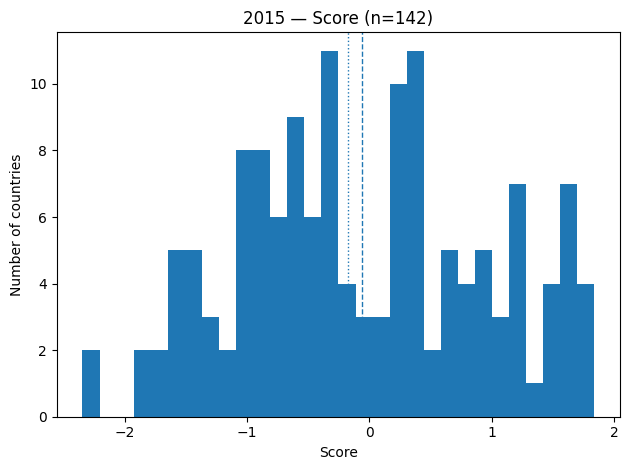

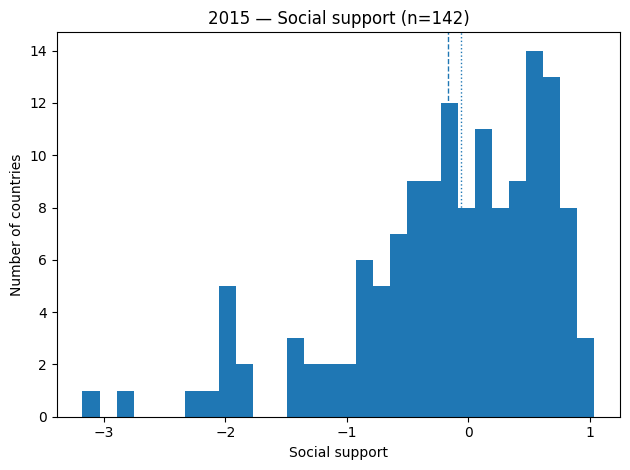

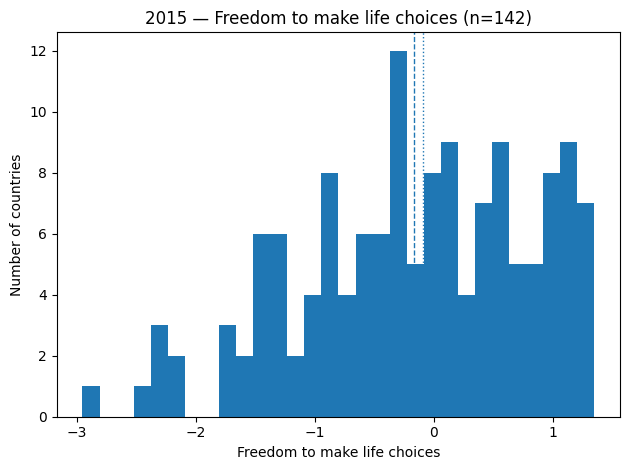

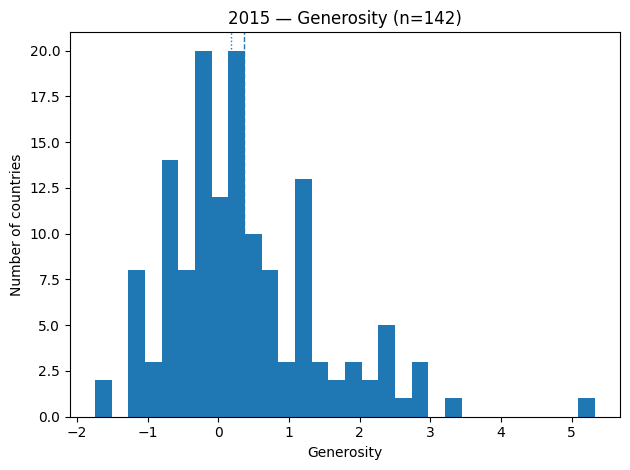

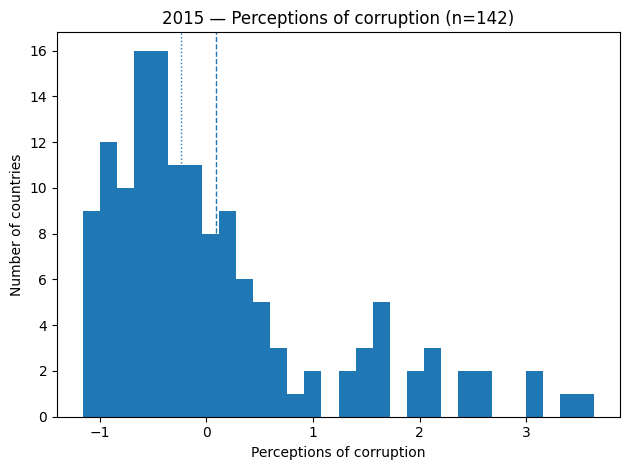

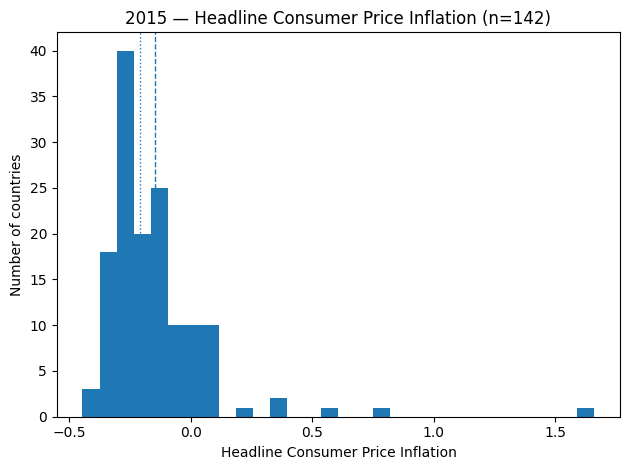

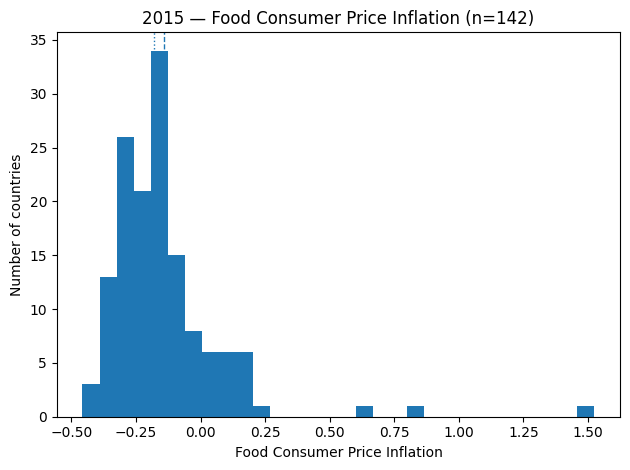

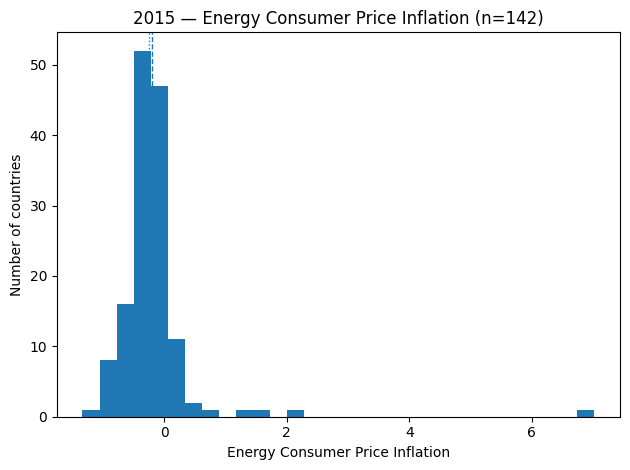

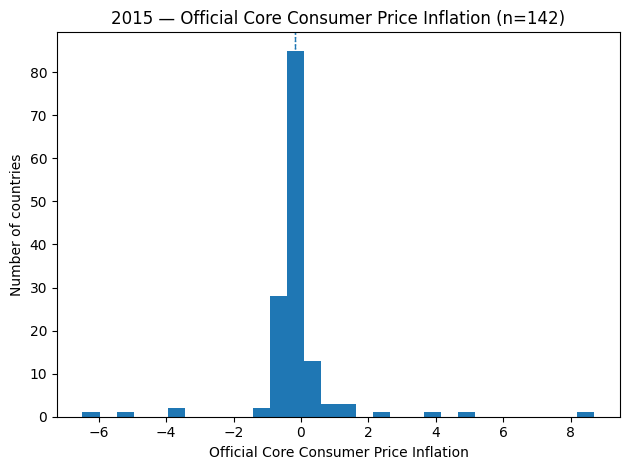

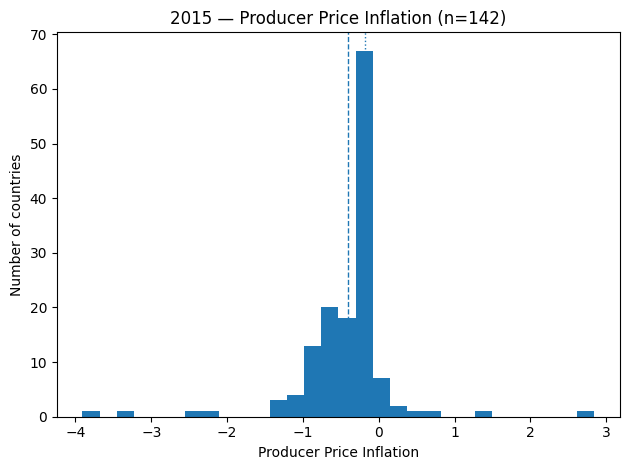

In [ ]:
year = 2015
indexes = [
    "Score",
    "Logged GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom to make life choices",
    "Generosity",
    "Perceptions of corruption",
    "Headline Consumer Price Inflation",
    "Food Consumer Price Inflation",
    "Energy Consumer Price Inflation",
    "Official Core Consumer Price Inflation",
    "Producer Price Inflation",
    "GDP Deflator Growth",
]

d = df[df["Year"] == year].copy()

for col in indexes:
    if col not in d.columns:
        continue
    x = pd.to_numeric(d[col], errors="coerce").dropna()
    if x.empty:
        continue

    plt.figure()
    plt.hist(x, bins=30)
    plt.title(f"{year} — {col} (n={len(x)})")
    plt.xlabel(col)
    plt.ylabel("Number of countries")

    # mean/median reference lines
    mu, med = float(x.mean()), float(x.median())
    plt.axvline(mu, linestyle="--", linewidth=1)
    plt.axvline(med, linestyle=":",  linewidth=1)
    plt.tight_layout()
    plt.show()


Here, you can observe the distribution of each score among all the countries. Things to look out for:
1. Skewedness
2. Spread and tails, if the tails is heavy, they may dictate heterogeneity, which may represent shocks i the country
3. Multi Modality - Two bumps means two distinct groups.

Be sure to plot multiple year graphs for comparison.

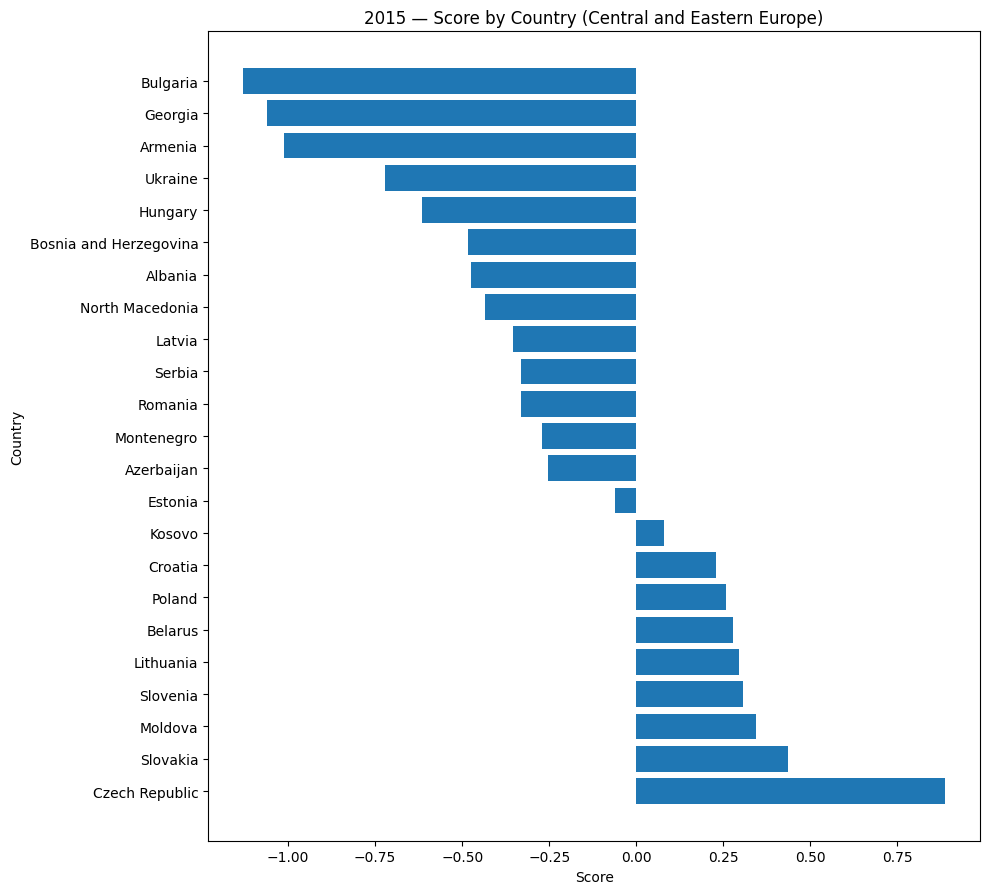

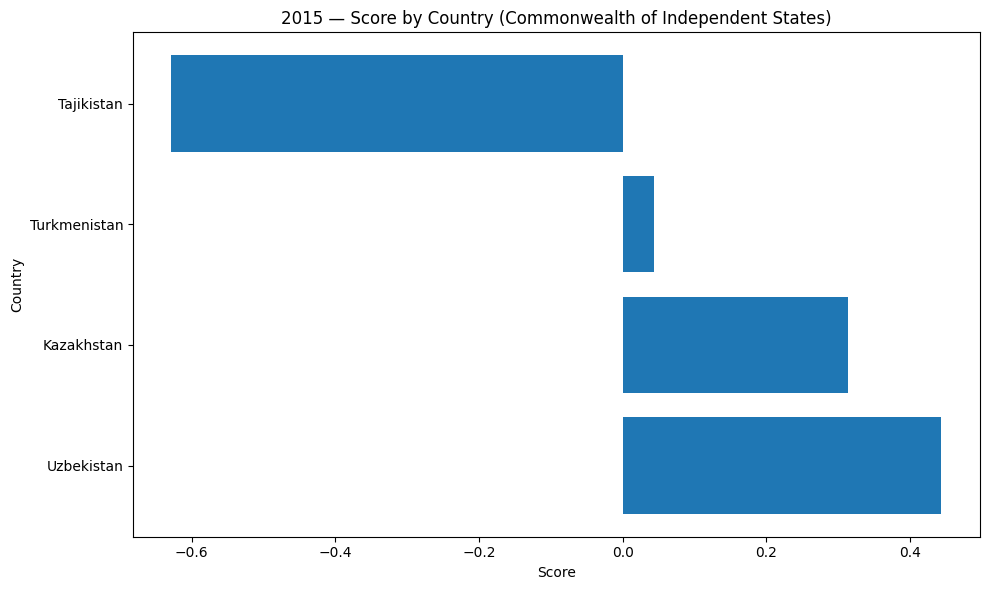

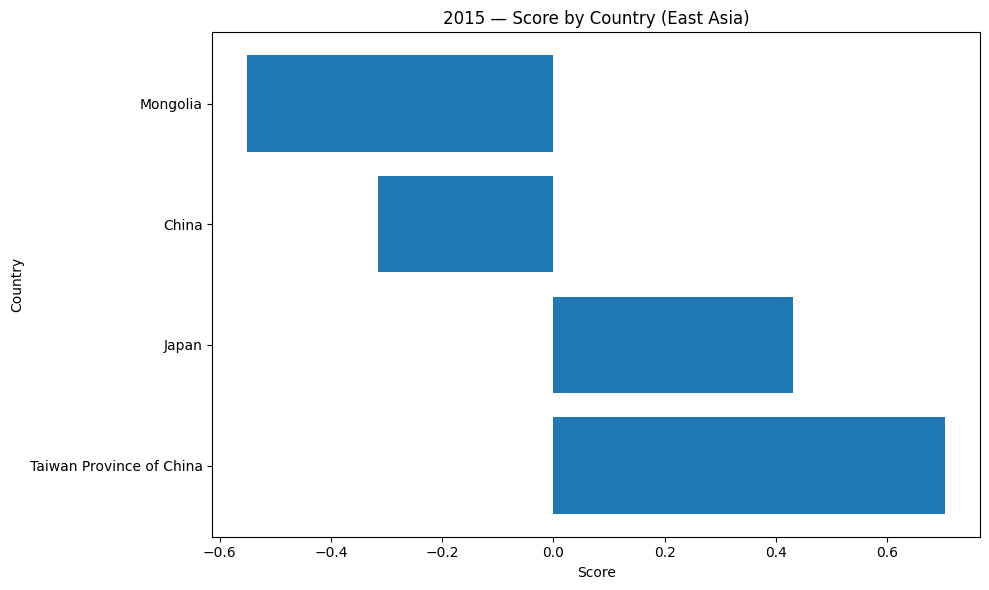

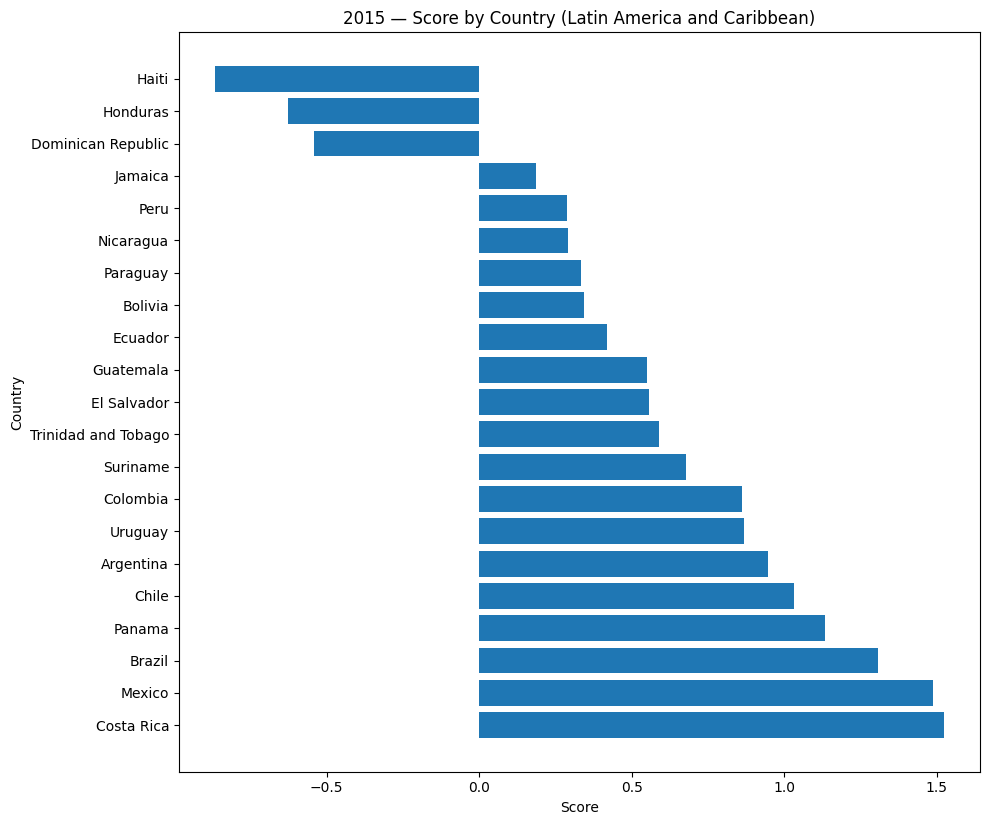

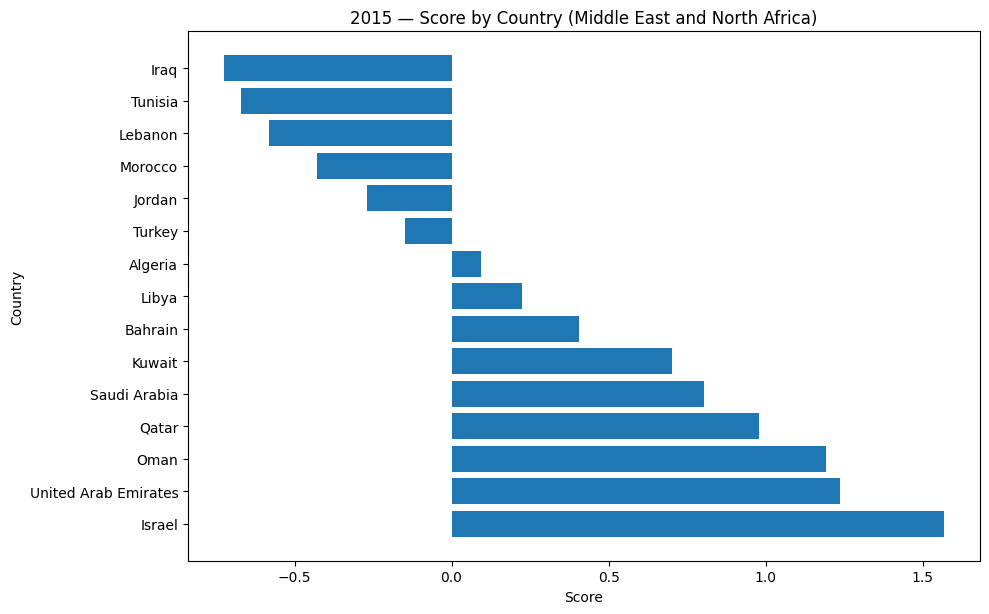

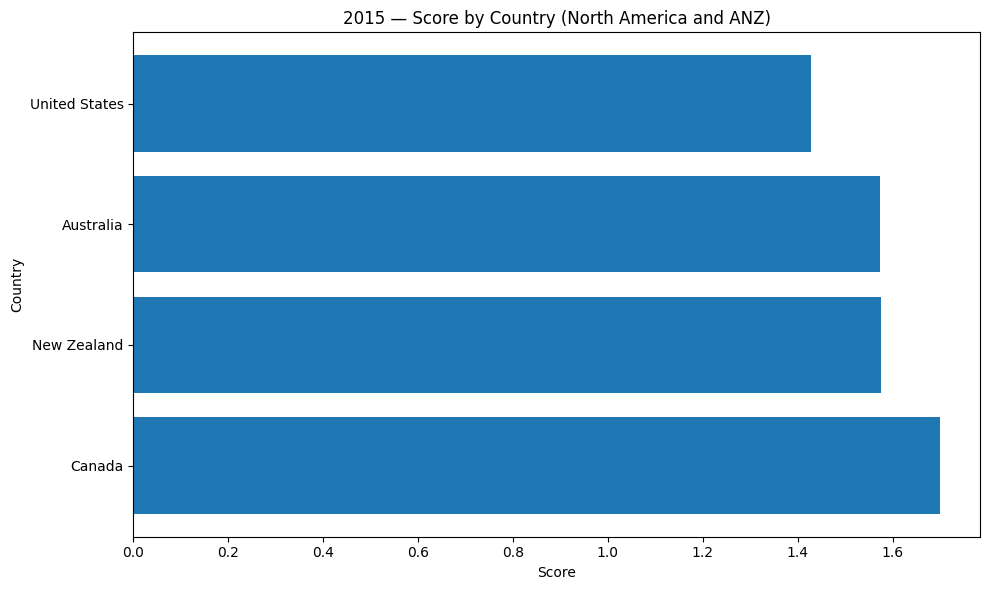

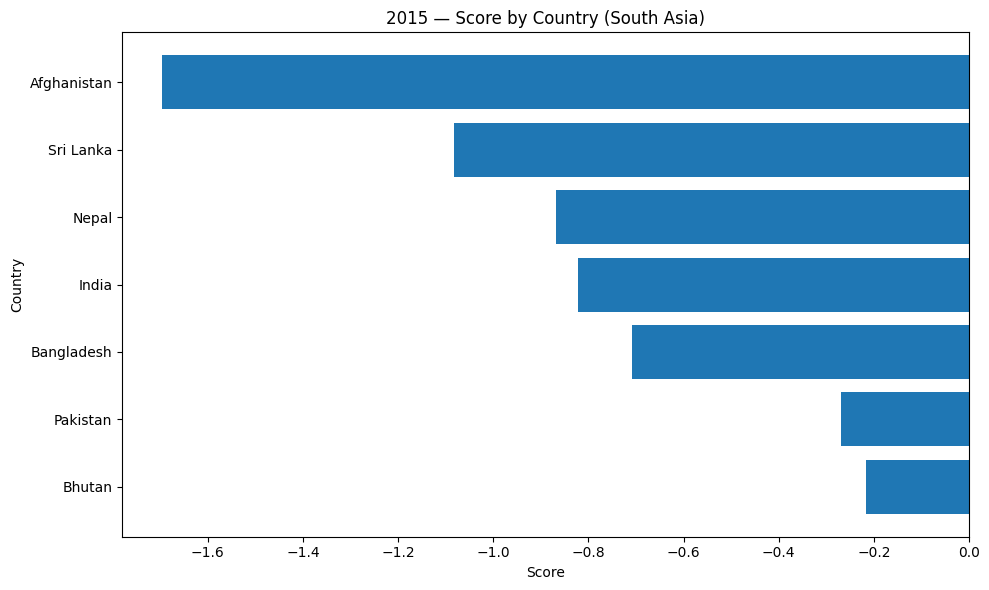

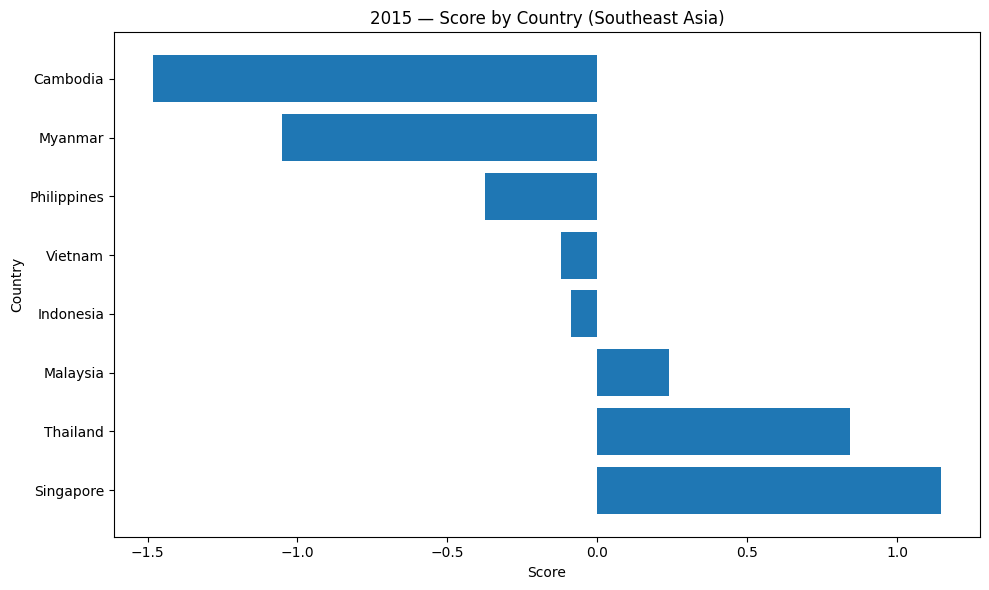

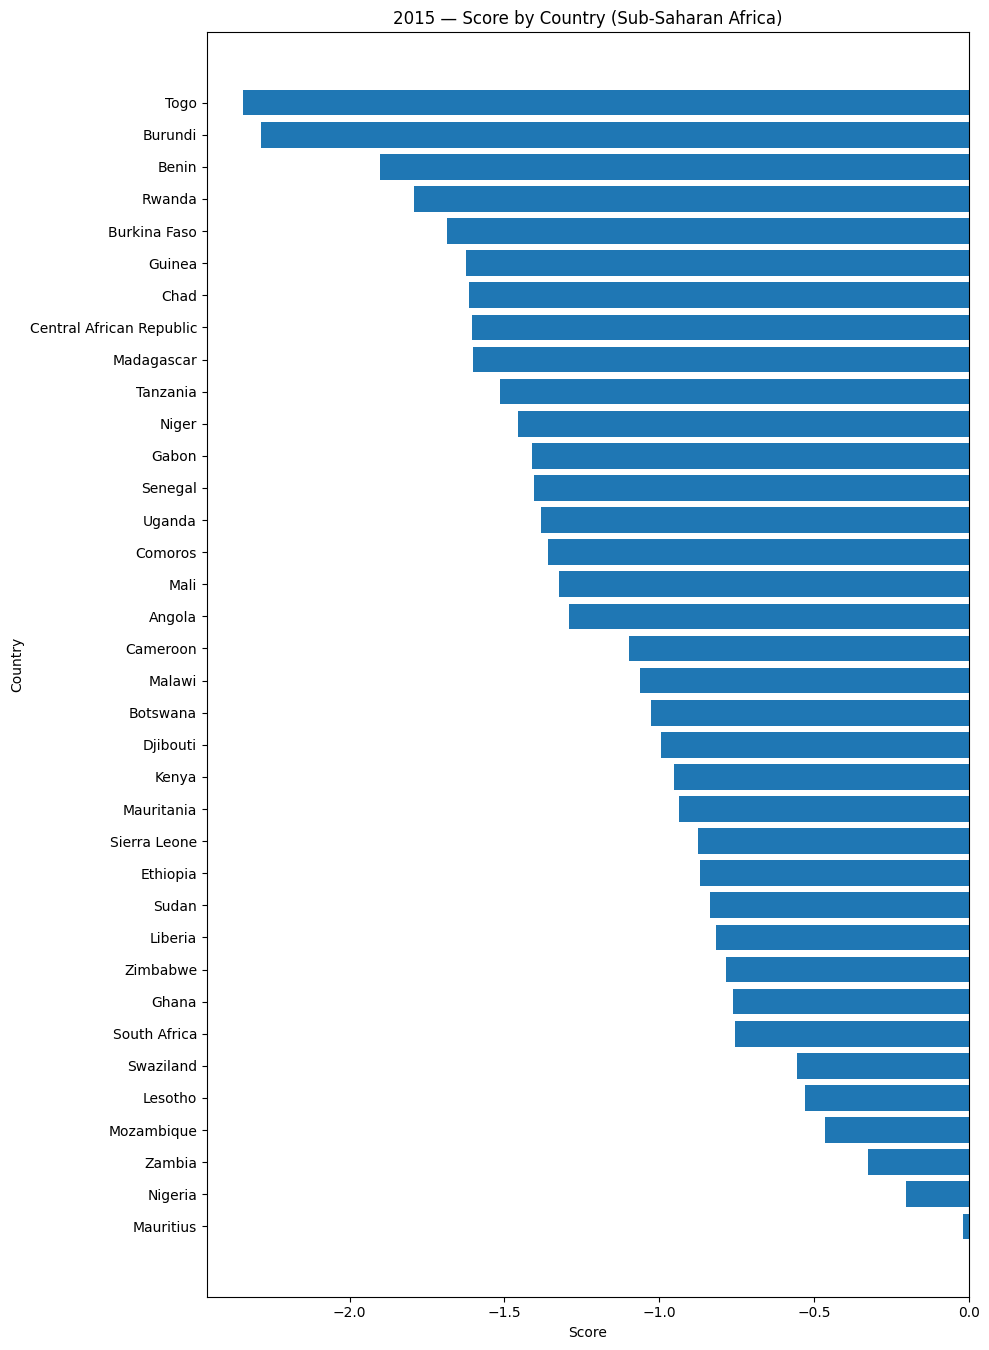

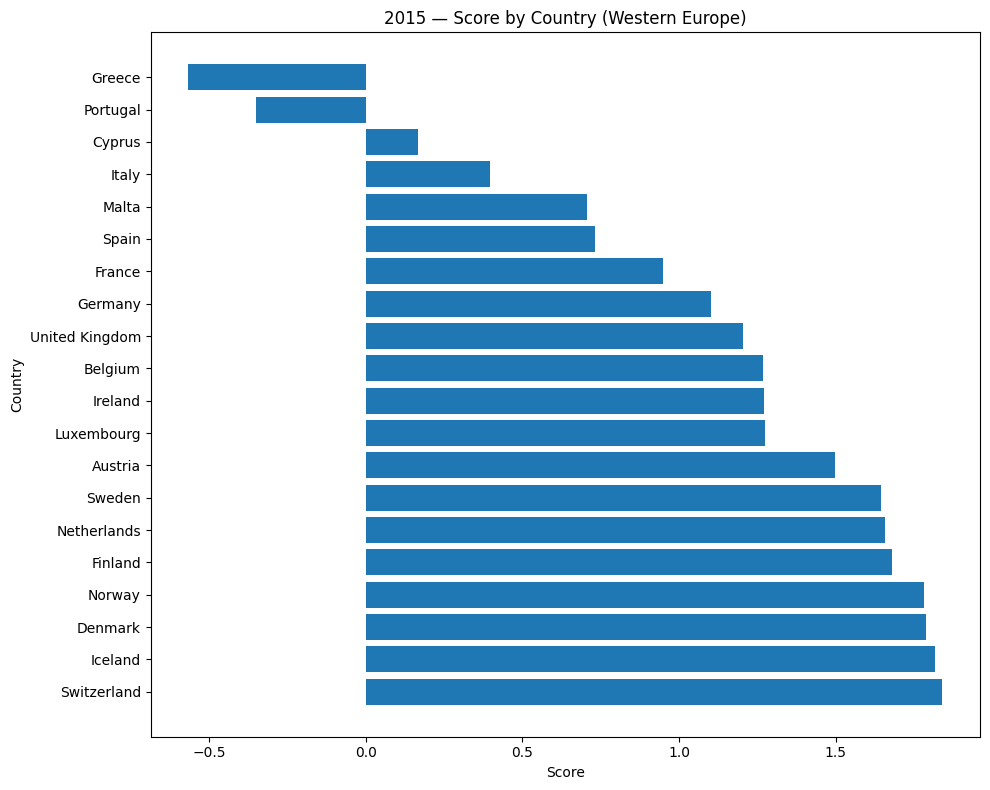

In [ ]:
year = 2015
index_name = "Score" #changable
region_col = "Continent/Region"  # changable
d = df[df["Year"] == year][["Country", region_col, index_name]].copy()
if region_col not in d.columns:
    raise ValueError(f"Column '{region_col}' not found; set region_col correctly.")

d[index_name] = pd.to_numeric(d[index_name], errors="coerce")
d = d.dropna(subset=[index_name])

for reg, g in d.groupby(region_col):
    g = g.sort_values(index_name, ascending=True)
    h = max(6, 0.35 * len(g) + 1)
    plt.figure(figsize=(10, h))
    plt.barh(g["Country"], g[index_name])
    plt.title(f"{year} — {index_name} by Country ({reg})")
    plt.xlabel(index_name)
    plt.ylabel("Country")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


For 2015, we can also rank each countries various indexes, seperated by region to get a better understanding.

Summary

In summary, for analytical purposes, these visualizations is sufficient. However, in actual data analysis, one must account for many time/entity fixed effects in this data. For country based indexes, many cultural/religious differences cause bias in scoring. Hence, it is best to remove fixed effects (e.g. FD, FE, DV) before building an ML nodel.

# Creating a general correlation heatmap

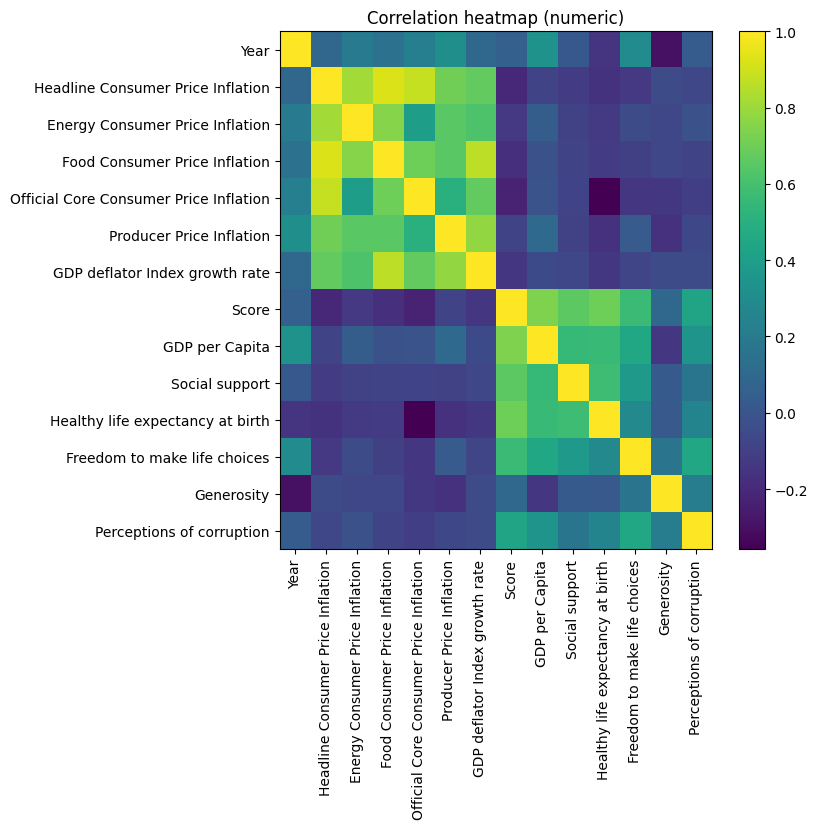

In [ ]:
#Correlation heatmap
if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)

    plt.figure(figsize=(max(8, len(num_cols) * 0.6), max(6, len(num_cols) * 0.6)))
    plt.imshow(corr, aspect='auto')
    plt.xticks(ticks=np.arange(len(num_cols)), labels=num_cols, rotation=90)
    plt.yticks(ticks=np.arange(len(num_cols)), labels=num_cols)
    plt.title('Correlation heatmap (numeric)')
    plt.colorbar()
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig("correlation_heatmap.png", dpi=150)
        print("Saved: correlation_heatmap.png")
    plt.show()
    plt.close()

    if TARGET_COL and TARGET_COL in num_cols:
        print("\nTop correlations with target:")
        print(corr[TARGET_COL].sort_values(ascending=False))
else:
    print("\nNot enough numeric columns for a correlation heatmap.")

/tmp/ipython-input-3301842261.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


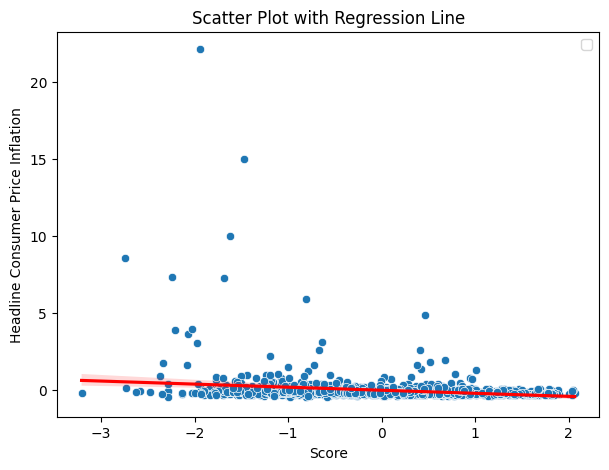

In [ ]:
# Scatter plot between Headline Consumer Price Inflation and Happiness Score
plt.figure(figsize=(7,5))
sns.scatterplot(x="Score", y="Headline Consumer Price Inflation", data=df)
sns.regplot(x="Score", y="Headline Consumer Price Inflation", data=df, scatter=False, color="red", line_kws={"label":"Regression Line"})
plt.xlabel("Score")
plt.ylabel("Headline Consumer Price Inflation")
plt.title("Scatter Plot with Regression Line")
plt.legend()
plt.show()

/tmp/ipython-input-1446008941.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


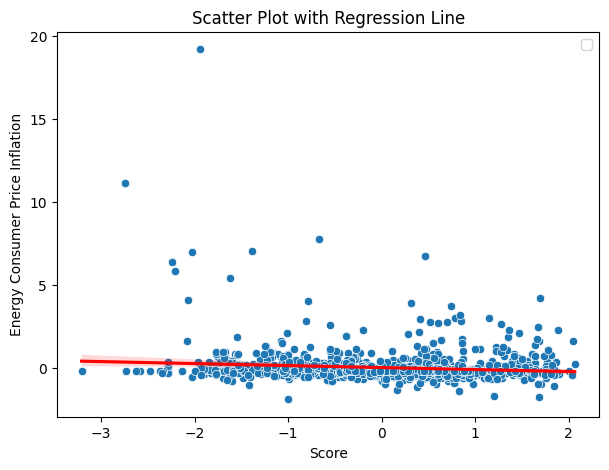

In [ ]:
# Scatter plot between Energy Consumer Price Inflation and Happiness Score
plt.figure(figsize=(7,5))
sns.scatterplot(x="Score", y="Energy Consumer Price Inflation", data=df)
sns.regplot(x="Score", y="Energy Consumer Price Inflation", data=df, scatter=False, color="red", line_kws={"label":"Regression Line"})
plt.xlabel("Score")
plt.ylabel("Energy Consumer Price Inflation")
plt.title("Scatter Plot with Regression Line")
plt.legend()
plt.show()

/tmp/ipython-input-89986303.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


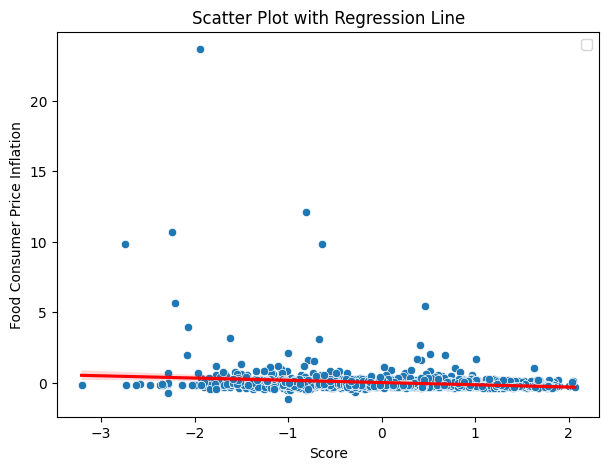

In [ ]:
# Scatter plot between Food Consumer Price Inflation and Happiness Score
plt.figure(figsize=(7,5))
sns.scatterplot(x="Score", y="Food Consumer Price Inflation", data=df)
sns.regplot(x="Score", y="Food Consumer Price Inflation", data=df, scatter=False, color="red", line_kws={"label":"Regression Line"})
plt.xlabel("Score")
plt.ylabel("Food Consumer Price Inflation")
plt.title("Scatter Plot with Regression Line")
plt.legend()
plt.show()

/tmp/ipython-input-550827318.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


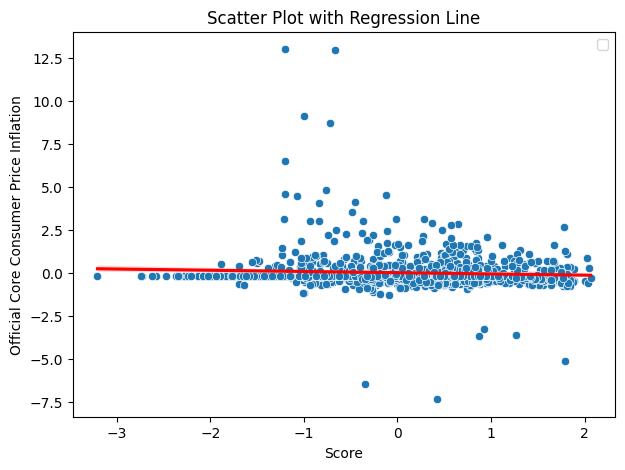

In [ ]:
# Scatter plot between Official Core Consumer Price Inflation and Happiness Score
plt.figure(figsize=(7,5))
sns.scatterplot(x="Score", y="Official Core Consumer Price Inflation", data=df)
sns.regplot(x="Score", y="Official Core Consumer Price Inflation", data=df, scatter=False, color="red", line_kws={"label":"Regression Line"})
plt.xlabel("Score")
plt.ylabel("Official Core Consumer Price Inflation")
plt.title("Scatter Plot with Regression Line")
plt.legend()
plt.show()

- The points are widely scattered and don’t seem to form a clear linear or nonlinear trend.

- This suggests that the Score variable does not strongly predict Consumer Price Inflation.

- There are some outliers. These outliers may distort correlation analysis and are worth investigating individually (e.g., data entry error or unusual economic events).

In [ ]:
from scipy.stats import pearsonr
df_clean = df[["Score", "Headline Consumer Price Inflation"]].dropna()
pearson_corr, pearson_p = pearsonr(df_clean["Score"], df_clean["Headline Consumer Price Inflation"])
print("Pearson correlation:", pearson_corr, " (p-value:", pearson_p, ")")

Pearson correlation: -0.1988220707972358  (p-value: 1.895547931317581e-12 )


In [ ]:
df_clean = df[["Score", "Energy Consumer Price Inflation"]].dropna()
pearson_corr, pearson_p = pearsonr(df_clean["Score"], df_clean["Energy Consumer Price Inflation"])
print("Pearson correlation:", pearson_corr, " (p-value:", pearson_p, ")")

Pearson correlation: -0.12028735484410275  (p-value: 2.3042850927600244e-05 )


In [ ]:
df_clean = df[["Score", "Food Consumer Price Inflation"]].dropna()
pearson_corr, pearson_p = pearsonr(df_clean["Score"], df_clean["Food Consumer Price Inflation"])
print("Pearson correlation:", pearson_corr, " (p-value:", pearson_p, ")")

Pearson correlation: -0.1594395450338615  (p-value: 1.83738123162766e-08 )


In [ ]:
df_clean = df[["Score", "Official Core Consumer Price Inflation"]].dropna()
pearson_corr, pearson_p = pearsonr(df_clean["Score"], df_clean["Official Core Consumer Price Inflation"])
print("Pearson correlation:", pearson_corr, " (p-value:", pearson_p, ")")

Pearson correlation: -0.0713093814521009  (p-value: 0.012293829227499732 )


/tmp/ipython-input-403832236.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


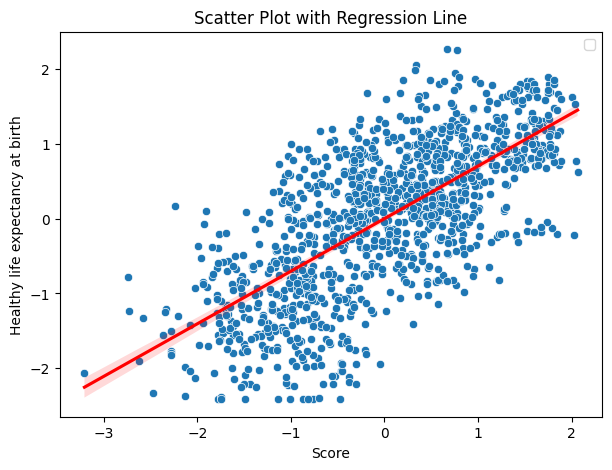

In [ ]:
# Scatter plot between Healthy life expectancy at birth and Happiness Score
plt.figure(figsize=(7,5))
sns.scatterplot(x="Score", y="Healthy life expectancy at birth", data=df)
sns.regplot(x="Score", y="Healthy life expectancy at birth", data=df, scatter=False, color="red", line_kws={"label":"Regression Line"})
plt.xlabel("Score")
plt.ylabel("Healthy life expectancy at birth")
plt.title("Scatter Plot with Regression Line")
plt.legend()
plt.show()

In [ ]:
df_clean = df[["Score", "Healthy life expectancy at birth"]].dropna()
pearson_corr, pearson_p = pearsonr(df_clean["Score"], df_clean["Healthy life expectancy at birth"])
print("Pearson correlation:", pearson_corr, " (p-value:", pearson_p, ")")

Pearson correlation: 0.7024220285939652  (p-value: 7.599158464667326e-184 )


/tmp/ipython-input-2076605420.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


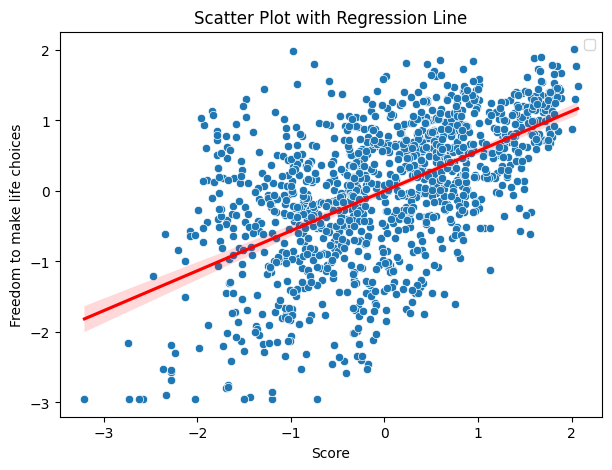

In [ ]:
# Scatter plot between Freedom to make life choices and Happiness Score
plt.figure(figsize=(7,5))
sns.scatterplot(x="Score", y="Freedom to make life choices", data=df)
sns.regplot(x="Score", y="Freedom to make life choices", data=df, scatter=False, color="red", line_kws={"label":"Regression Line"})
plt.xlabel("Score")
plt.ylabel("Freedom to make life choices")
plt.title("Scatter Plot with Regression Line")
plt.legend()
plt.show()

In [ ]:
df_clean = df[["Score", "Freedom to make life choices"]].dropna()
pearson_corr, pearson_p = pearsonr(df_clean["Score"], df_clean["Freedom to make life choices"])
print("Pearson correlation:", pearson_corr, " (p-value:", pearson_p, ")")

Pearson correlation: 0.5657229892289415  (p-value: 3.800467710415891e-105 )


/tmp/ipython-input-523549818.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


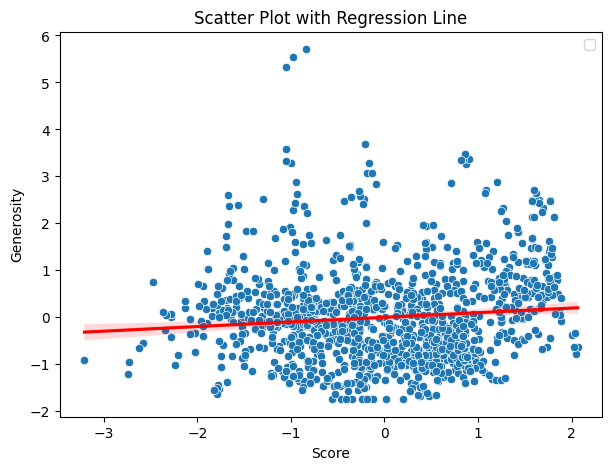

In [ ]:
# Scatter plot between Generosity and Happiness Score
plt.figure(figsize=(7,5))
sns.scatterplot(x="Score", y="Generosity", data=df)
sns.regplot(x="Score", y="Generosity", data=df, scatter=False, color="red", line_kws={"label":"Regression Line"})
plt.xlabel("Score")
plt.ylabel("Generosity")
plt.title("Scatter Plot with Regression Line")
plt.legend()
plt.show()

In [ ]:
df_clean = df[["Score", "Generosity"]].dropna()
pearson_corr, pearson_p = pearsonr(df_clean["Score"], df_clean["Generosity"])
print("Pearson correlation:", pearson_corr, " (p-value:", pearson_p, ")")

Pearson correlation: 0.09828526105504357  (p-value: 0.0005509789461853662 )


- Healthy life expectancy shows a strong positive correlation with Score → higher Scores are linked with longer healthy lifespans.

- Freedom to make life choices has a moderate positive correlation with Score → more freedom generally aligns with higher well-being, though with variability.

- Generosity shows only a very weak positive correlation with Score → little evidence that generosity alone explains differences in well-being.

- Overall, life expectancy is the strongest driver, followed by freedom, while generosity has minimal influence.

## Time Series Analysis

### Subtask:
Filter the data for a specific country and sort it by year for time series analysis.


**Reasoning**:
Filter the DataFrame for a specific country and sort by year for time series analysis.



In [ ]:
selected_country = 'United States'
df_country = df[df['Country'] == selected_country].copy()
df_country = df_country.sort_values(by='Year')
display(df_country.head())

,Headline Consumer Price Inflation,Energy Consumer Price Inflation,Food Consumer Price Inflation,Official Core Consumer Price Inflation,Producer Price Inflation,GDP deflator Index growth rate,Score,GDP per Capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Country,Year,Continent/Region
1178,-0.288914,-0.234716,-0.234342,-0.272693,-0.508373,-0.193132,1.427561,0.804659,0.572944,1.119259,0.557160,1.821609,0.221365,United States,2015,North America and ANZ
1179,-0.242891,0.696681,-0.292271,-0.183705,-0.389505,-0.190002,1.414343,1.055629,-0.026478,0.779876,0.142989,1.908020,0.132557,United States,2016,North America and ANZ
1180,-0.207681,0.070109,-0.270805,-0.268954,-0.215228,-0.163492,1.316529,1.140353,1.092721,0.760555,0.298025,1.746299,0.019234,United States,2017,North America and ANZ
1181,-0.195440,1.252806,-0.249971,-0.200263,-0.162569,-0.146886,1.222239,0.812379,1.246357,0.943849,0.563333,0.843263,-0.003696,United States,2018,North America and ANZ
1182,-0.220728,0.976097,-0.270669,-0.188110,-0.273279,-0.166529,1.227527,0.889805,1.204248,1.169312,-0.034678,0.745473,-0.047144,United States,2019,North America and ANZ


## Visualize time series

### Subtask:
Plot the selected time series data to observe trends and patterns over time.


**Reasoning**:
Plot the 'Score' time series data over 'Year' for the selected country to visualize trends and patterns.



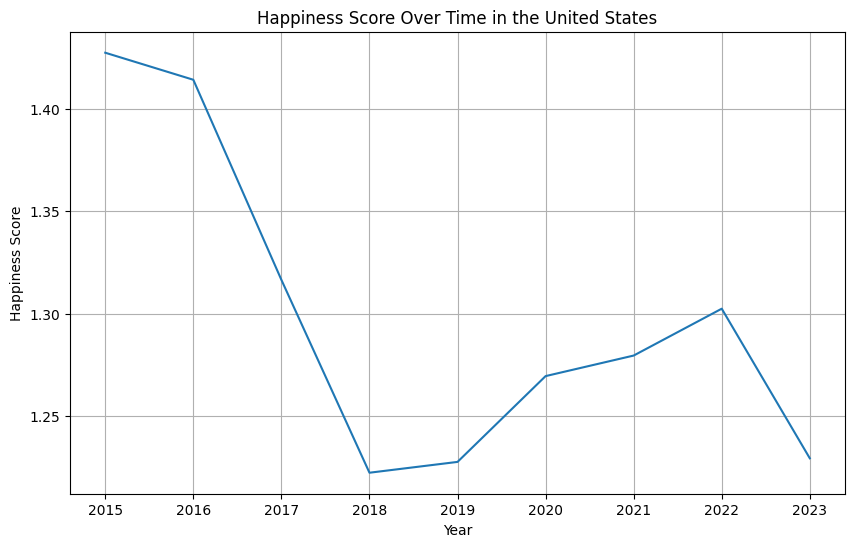

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_country['Year'], df_country['Score'])
plt.title("Happiness Score Over Time in the United States")
plt.xlabel("Year")
plt.ylabel("Happiness Score")
plt.grid(True)
plt.show()

## Analyze trends

### Subtask:
Use statistical methods or visualization to analyze trends in the time series data.


**Reasoning**:
Calculate the rolling mean and plot the original and rolling mean time series data.



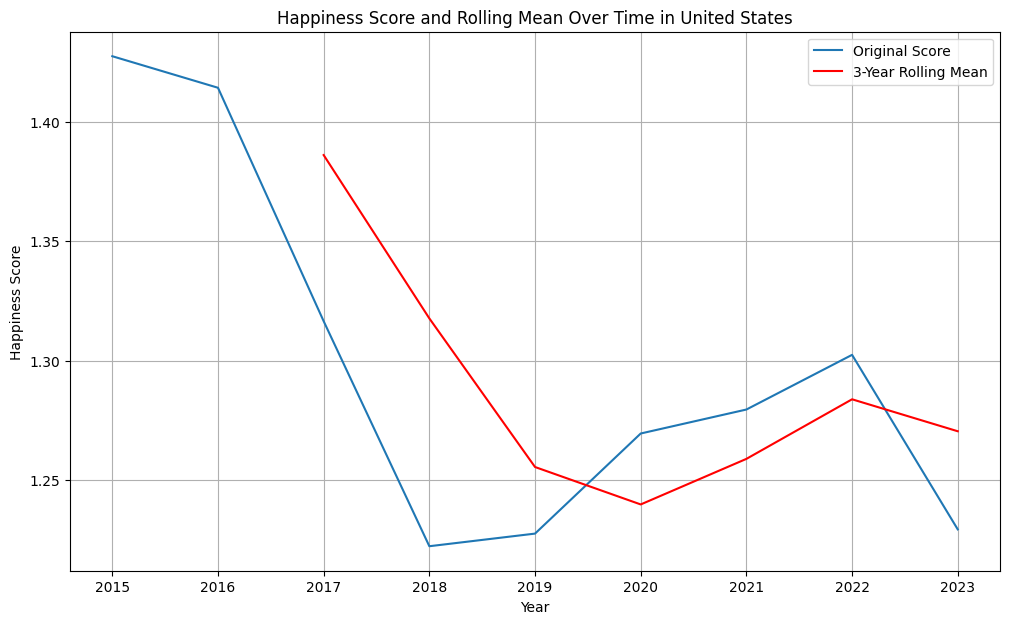

In [ ]:
df_country['Rolling_Mean_Score'] = df_country['Score'].rolling(window=3).mean()

plt.figure(figsize=(12, 7))
plt.plot(df_country['Year'], df_country['Score'], label='Original Score')
plt.plot(df_country['Year'], df_country['Rolling_Mean_Score'], label='3-Year Rolling Mean', color='red')
plt.title(f"Happiness Score and Rolling Mean Over Time in {selected_country}")
plt.xlabel("Year")
plt.ylabel("Happiness Score")
plt.legend()
plt.grid(True)
plt.show()

## Analyze seasonality

### Subtask:
Use statistical methods or visualization to analyze seasonality in the time series data.


## Analyze autocorrelation

### Subtask:
Calculate and plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) to understand the correlation between a time series and its lagged values.


**Reasoning**:
Calculate and plot the ACF and PACF to understand the correlation between the time series and its lagged values.



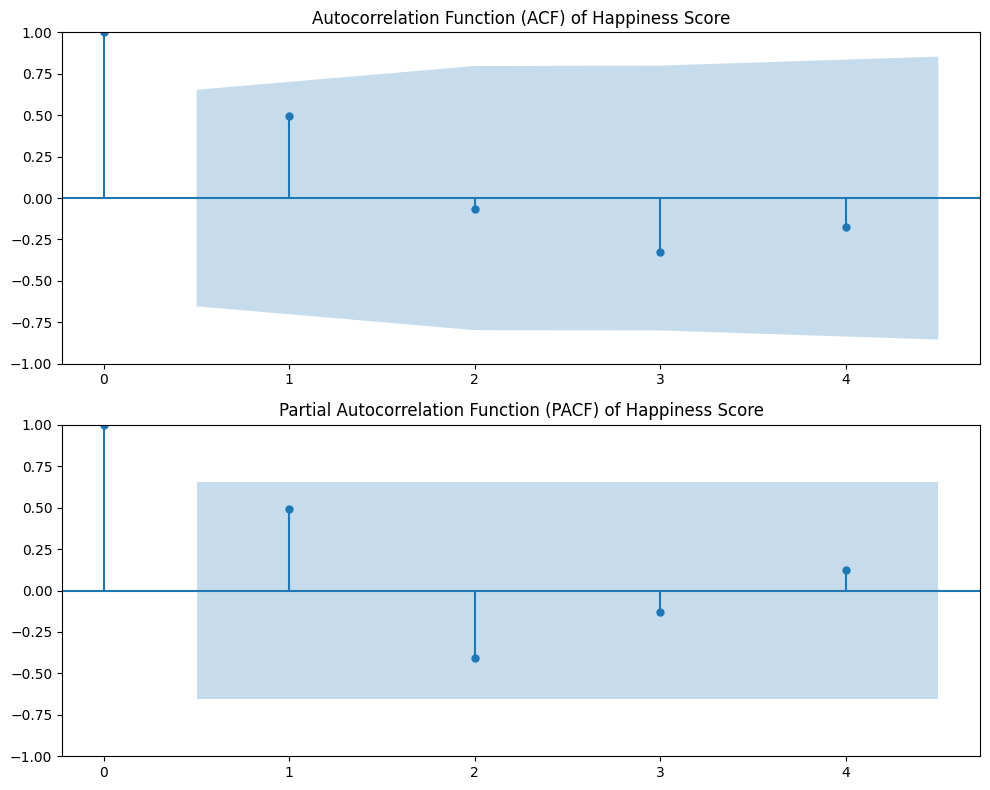

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df_country['Score'].dropna(), ax=axes[0], title='Autocorrelation Function (ACF) of Happiness Score')
plot_pacf(df_country['Score'].dropna(), ax=axes[1], title='Partial Autocorrelation Function (PACF) of Happiness Score')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

* The happiness score in the United States shows a general increasing trend over the years based on the time series plot and the 3-year rolling mean.
* Traditional seasonality analysis was not applicable due to the yearly nature of the data. Visual inspection of the time series plot did not reveal strong evidence of clear cyclical patterns.
* The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots were generated, showing the correlation between the happiness scores and their lagged values. The specific patterns in these plots provide insights into the time series structure and potential autoregressive or moving average components.

### Insights or Next Steps

* The presence of autocorrelation suggests that past happiness scores have some influence on future scores, indicating that time series models could be appropriate for forecasting.
* Further analysis could involve fitting time series models (e.g., ARIMA) to the data to capture the identified trend and autocorrelation structure for forecasting future happiness scores.
